In [1]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm

In [2]:
sample = [-27.020,3.570,8.191,9.898,9.603,9.945,10.056]
sample = np.array([[i] for i in sample])

In [9]:
import numpy as np
import pymc as pm

(nb_stateux, sample_length) = sample.shape
print (nb_stateux, sample_length)

v_mus = np.array([pm.Normal("mu%d" % i, mu=0, tau=0.001) for i in np.arange(sample_length)])
v_sigmas = [pm.Uniform("sigma%d" % k, lower=0, upper=40) for k in np.arange(nb_stateux)]
v_taus = [pm.Lambda("tau%d" % k, lambda sigma=v_sigmas[k]: 1/sigma**2) for k in np.arange(nb_stateux)]

x = np.array([[pm.Normal("x%d_%d" % (k,i), mu=v_mus[i], tau=v_taus[k], 
                         observed=True, value=np.array(sample[k,i])) for i in np.arange(sample_length)]
              for k in np.arange(nb_stateux)])

mcmc = pm.MCMC([v_mus, v_sigmas, v_taus, x])
mcmc.sample(20000,4000)

mu_traces = [np.array(mcmc.trace('mu%d' % k)[:]) for k in np.arange(sample_length)]
sigma_traces = [np.array(mcmc.trace("sigma%d" % i)[:]) for i in np.arange(nb_stateux)]

7 1
 [-----------------100%-----------------] 20000 of 20000 complete in 7.0 sec

In [6]:
%history -f 7stateux_model.py -l 1

File '7stateux_model.py' exists. Overwrite? y
Overwriting file.


8.95896997679


/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


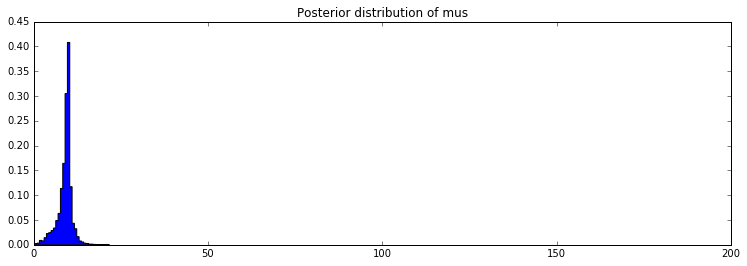

In [10]:
figsize(12.5, 4)
plt.title("Posterior distribution of mus")
for i in np.arange(sample_length):
    plt.hist(mu_traces[i], bins=50, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,200))
    print (mu_traces[i].mean())

29.0187815657
16.0813733636
11.3804224309
10.3437525327
10.3473643999
10.6971919445
10.4598238653


/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


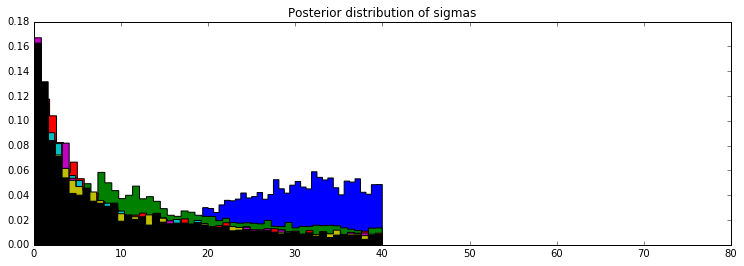

In [11]:
figsize(12.5, 4)
plt.title("Posterior distribution of sigmas")
for i in np.arange(nb_stateux):
    plt.hist(sigma_traces[i], bins=50, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,80))
    print (sigma_traces[i].mean())

In [19]:
# Now going parallel

from IPython.parallel import Client
client = Client()

direct         = client[:]
direct.block   = True
print (direct)

def checkhostname():
    import socket
    return socket.gethostname()

direct.apply(checkhostname)

import numpy as np
with direct.sync_imports():
    import pymc as pm
    import numpy as np

<DirectView [0, 1, 2, 3]>
importing pymc on engine(s)
importing numpy on engine(s)


In [20]:
export_dict = {k: globals()[k] for k in ('sample', 'nb_stateux')}
direct.push(export_dict, block=True)

model_script = open('7stateux_model.py').read()
print (model_script)

import numpy as np
import pymc as pm

(nb_stateux, sample_length) = sample.shape
print (nb_stateux, sample_length)

v_mus = np.array([pm.Normal("mu%d" % i, mu=0, tau=0.001) for i in np.arange(sample_length)])
v_sigmas = [pm.Uniform("sigma%d" % k, lower=0, upper=100) for k in np.arange(nb_stateux)]
v_taus = [pm.Lambda("tau%d" % k, lambda sigma=v_sigmas[k]: 1/sigma**2) for k in np.arange(nb_stateux)]

x = np.array([[pm.Normal("x%d_%d" % (k,i), mu=v_mus[i], tau=v_taus[k], 
                         observed=True, value=np.array(sample[k,i])) for i in np.arange(sample_length)]
              for k in np.arange(nb_stateux)])

mcmc = pm.MCMC([v_mus, v_sigmas, v_taus, x])
mcmc.sample(80000,1000)

mu_traces = [np.array(mcmc.trace('mu%d' % k)[:]) for k in np.arange(sample_length)]
sigma_traces = [np.array(mcmc.trace("sigma%d" % i)[:]) for i in np.arange(nb_stateux)]



In [21]:
%time direct.execute(model_script)

CPU times: user 278 ms, sys: 21.5 ms, total: 300 ms
Wall time: 41.8 s


<AsyncResult: finished>

In [10]:
def get_trace(var_name):
    all_traces = direct.pull(var_name)
    a = len(all_traces)
    b = len(all_traces[0])

    y = [np.array([all_traces[i][j] for i in range(a)]).flatten() for j in range(b)]
    
    return y

mu_traces = get_trace("mu_traces")
sigma_traces = get_trace("sigma_traces")

print (mu_traces)
print (len(mu_traces), len(mu_traces[0]))

[array([ 9.04911765,  9.04911765,  9.04911765, ...,  9.73326905,
        9.73326905,  9.73326905])]
1 76000


8.57704481079


/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


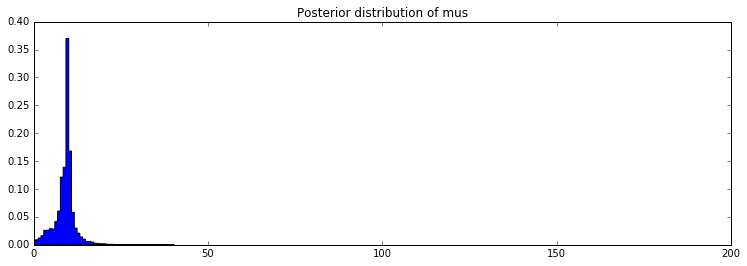

In [12]:
figsize(12.5, 4)
plt.title("Posterior distribution of mus")
for i in np.arange(sample_length):
    plt.hist(mu_traces[i], bins=100, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,200))
    print (mu_traces[i].mean())

/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


54.6794419774 52.6800449496
31.598311509 22.730626947
24.2974446132 13.7418844946
22.6980122096 11.7779203676
22.2514123955 10.5854931629
21.8232673705 10.4052730109
22.4638612012 11.6717816133


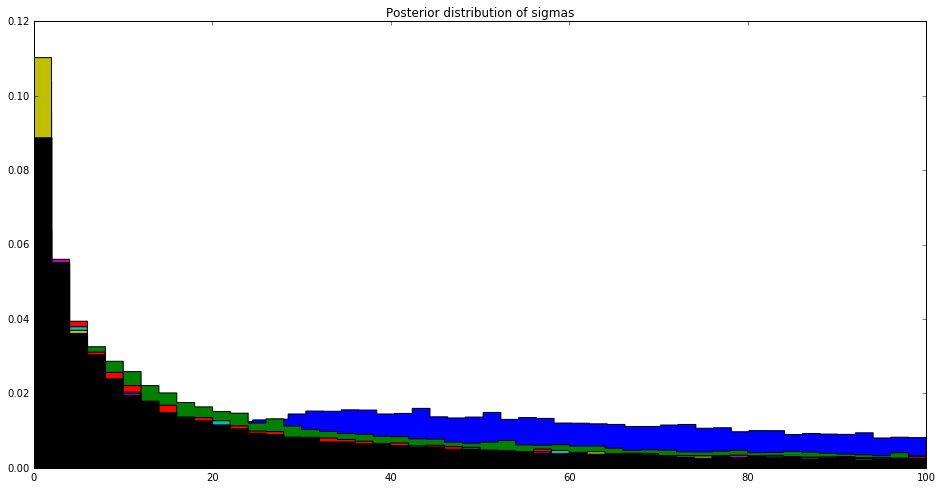

In [14]:
figsize(16, 8)
plt.title("Posterior distribution of sigmas")
for i in np.arange(nb_stateux):
    plt.hist(sigma_traces[i], bins=50, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,100))
    print (sigma_traces[i].mean(), np.median(sigma_traces[i]))